In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib

import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil
import scipy
import netCDF4 as nc

sys.path.append(r"/home/mike/work/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.neutral_transport import NeutralTransport
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.balance1d import *
from hermes3.selectors import *

from hermes3.utils import *
# from code_comparison.code_comparison import *

%load_ext autoreload
%autoreload 2

In [2]:
db = CaseDB(
    case_dir = r"/home/mike/work/cases",
    grid_dir = r"/home/mike/work/cases"
    )

In [3]:
toload = [ 
    # dict(name="base", id="upst1be-2e19_MASTER_RERUN_term_decomposition", unnormalise = True), 
    dict(name="base", id="upst1bi-2e19_MASTER_RERUN_timestep_1", unnormalise = True), 

]
cs = {}
for case in toload:
    cs[case["name"]] = db.load_case_2D(case["id"], use_squash = False, verbose = True, unnormalise = case["unnormalise"], unnormalise_geom = case["unnormalise"])
    cs[case["name"]].extract_2d_tokamak_geometry()


- Reading case upst1bi-2e19_MASTER_RERUN_timestep_1
-----------------------


/home/mike/work/xbout/xbout/load.py:1129: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes


## Show global fluctuations

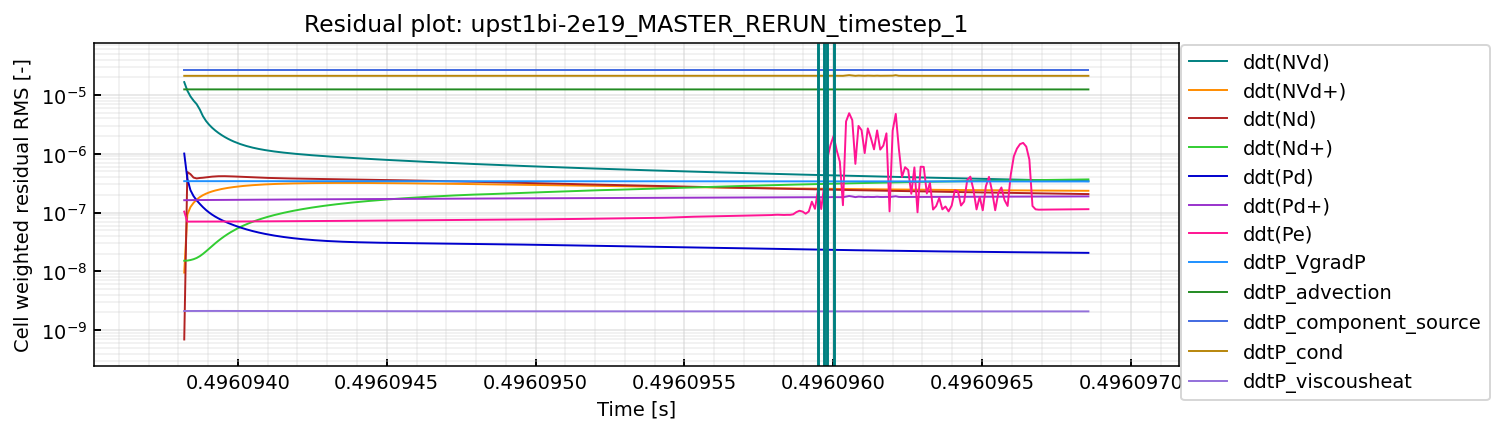

In [7]:
name = "base"
ds  = cs[name].ds.isel(t=slice(None,-1))

fig, ax = plt.subplots(figsize = (10,3))
plot_ddt(cs[name], ax = ax, trim_timestep = 1)


ds_slices = []
tind_slices = []

# time_slices = [0.4976125, 0.497615, 0.4976175, 0.49762]
# time_slices = [0.49762, 0.4976205, 0.4976208]
time_slices = [0.49609595, 0.496095975, 0.496095985, 0.4960960]

ylim = ax.get_ylim()

for time in time_slices:
    ds_1 = ds.sel(t = time, method = "nearest")
    tind_1 = ds_1["t"].values
    ax.vlines(tind_1, *ylim)
    
    ds_slices.append(ds_1)
    tind_slices.append(tind_1)
    
    
ax.set_ylim(ylim)
ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))


# Decompose ddt(Pe) in the core

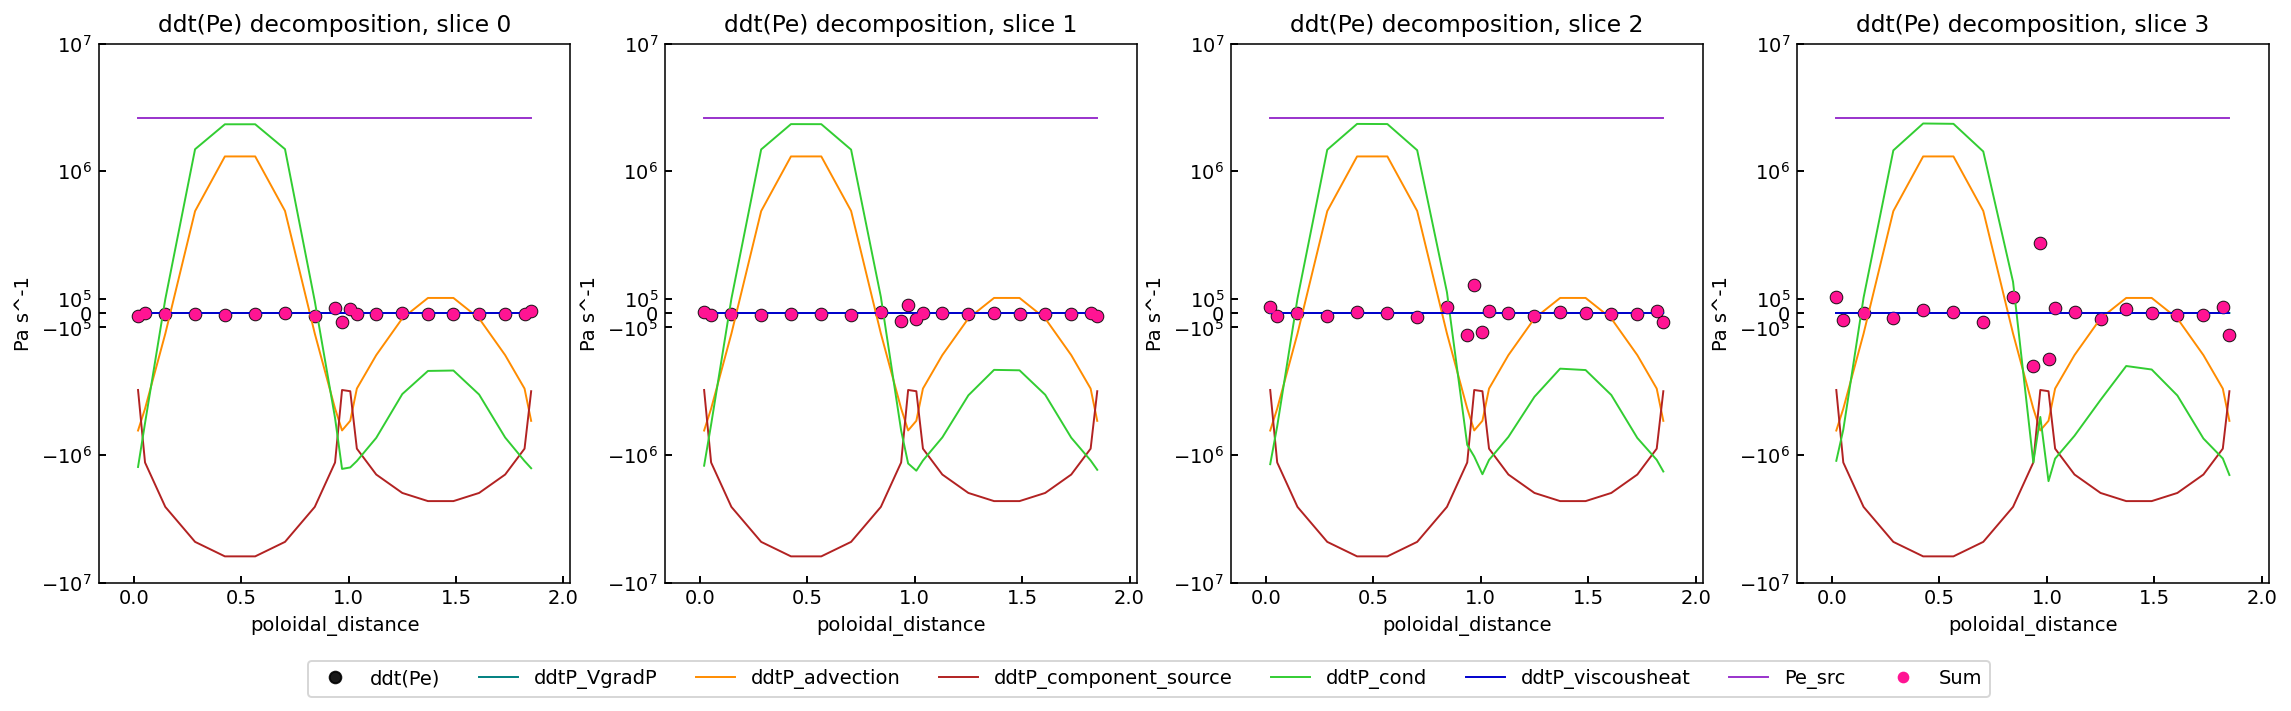

In [102]:
fig, axes = plt.subplots(1, len(time_slices), figsize = (5*len(time_slices),5))


for tind, t in enumerate(time_slices):

    ax = axes[tind]
    
    ds = cs[name].ds
    m = ds.metadata
    ixseps = m["ixseps1"]
    
    core = ds.hermesm.select_custom_core_ring(0)

    core["ddt(Pe)"].sel(t=t, method = "nearest").plot(ax = ax, x = "poloidal_distance", marker = "o", lw = 0, c = "k", alpha = 0.9,  label = "ddt(Pe)" if tind == 0 else None)
    
    # core["ddt(Pe)"].sel(t=t, method = "nearest").sel(theta = 20, method = "nearest").plot(ax = ax, x = "poloidal_distance", marker = "o", lw = 0, c = "k", alpha = 0.9,  label = "ddt(Pe)" if tind == 0 else None)

    core_sum = 0
    for param in ["ddtP_VgradP", "ddtP_advection", "ddtP_component_source", "ddtP_cond", "ddtP_viscousheat", "Pe_src"]:
        core[param].sel(t=t, method = "nearest").plot(ax = ax, x = "poloidal_distance", lw = 1, label = param if tind == 0 else None)
        core_sum += core[param].sel(t=t, method = "nearest")

    core_sum.plot(ax = ax, x = "poloidal_distance", lw = 0, marker = "o", c = "deeppink", ms = 5, label = "Sum" if tind == 0 else None)

    ax.set_title(f"ddt(Pe) decomposition, slice {tind}")
    
    ax.set_ylabel("Pa s^-1")
    ax.set_yscale("symlog", linthresh = 1e6)
    ax.set_ylim(-1e7, 1e7)
    
fig.legend(loc = "upper center", ncols = 8, bbox_to_anchor = (0.5, 0),fontsize = "medium")


## Core ring temp

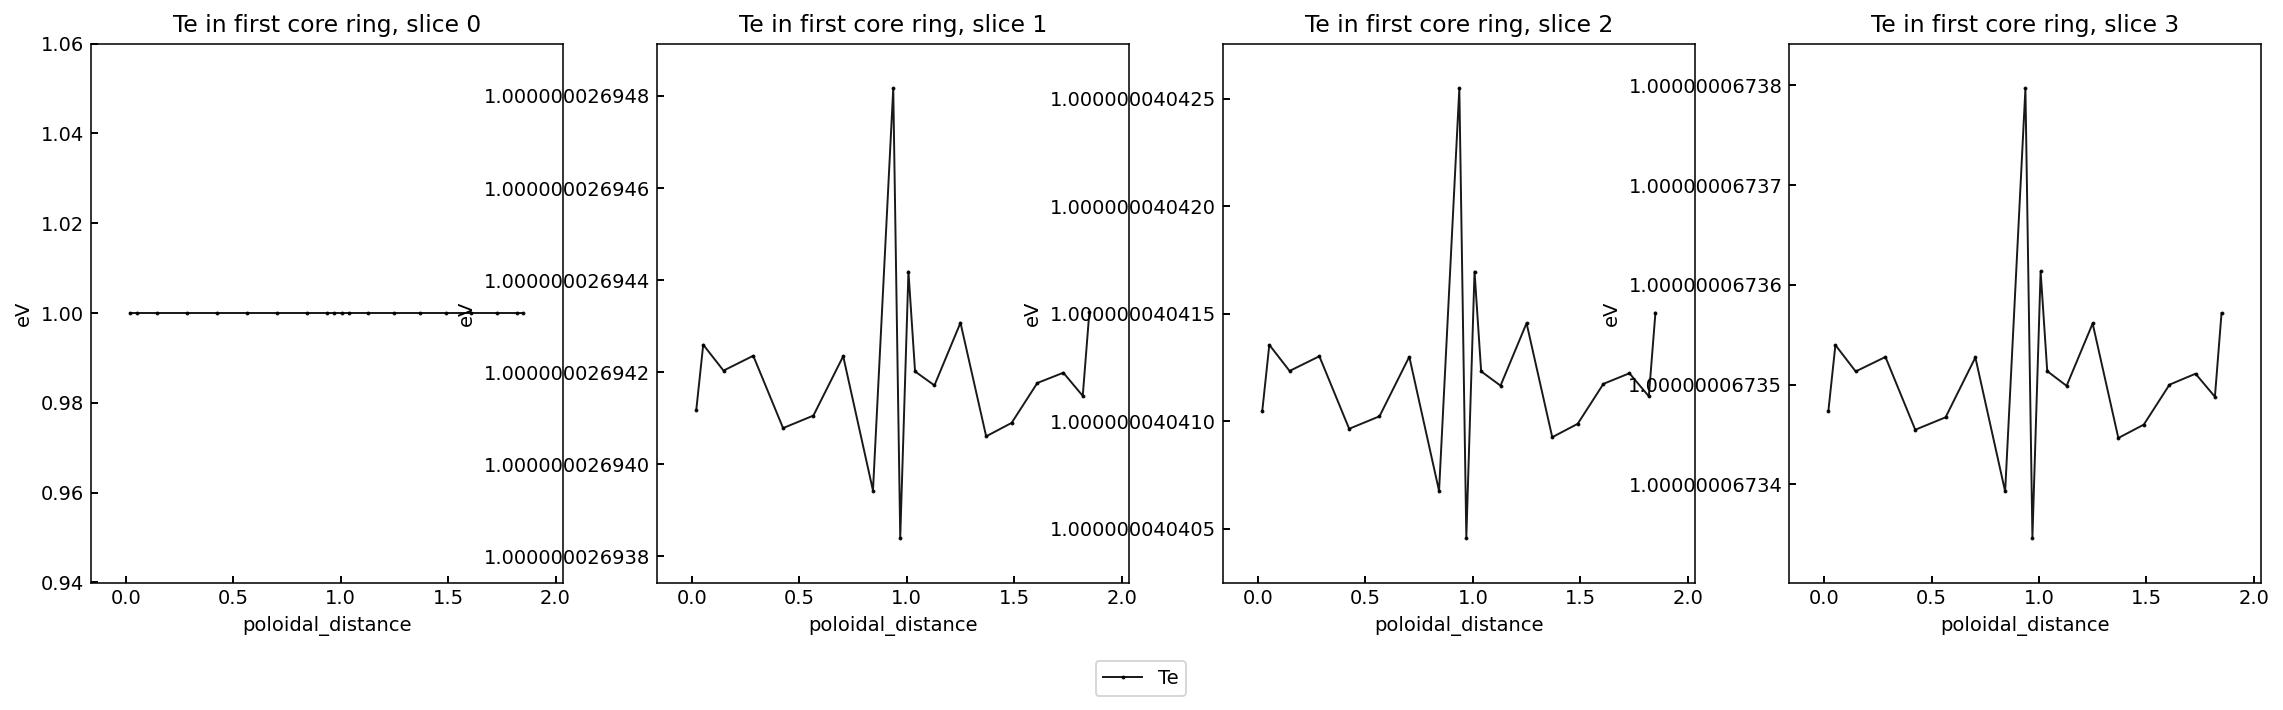

In [103]:
fig, axes = plt.subplots(1, len(time_slices), figsize = (5*len(time_slices),5))


for tind, t in enumerate(time_slices):

    ax = axes[tind]
    
    ds = cs[name].ds
    m = ds.metadata
    ixseps = m["ixseps1"]
    
    core = ds.hermesm.select_custom_core_ring(0)

    Te = core["Te"].sel(t=t, method = "nearest")
    Te_0 = core["Te"].sel(t=time_slices[0], method = "nearest")
    (Te / Te_0).plot(ax = ax, x = "poloidal_distance", marker = "o", lw = 1, ms = 1,  c = "k", alpha = 0.9,  label = "Te" if tind == 0 else None)

    ax.set_title(f"Te in first core ring, slice {tind}")
    ax.set_ylabel("eV")
    # ax.set_yscale("symlog", linthresh = 1e6)
    # ax.set_ylim(-1e7, 1e7)
    
fig.legend(loc = "upper center", ncols = 8, bbox_to_anchor = (0.5, 0),fontsize = "medium")


## Core ring conductive heat flux

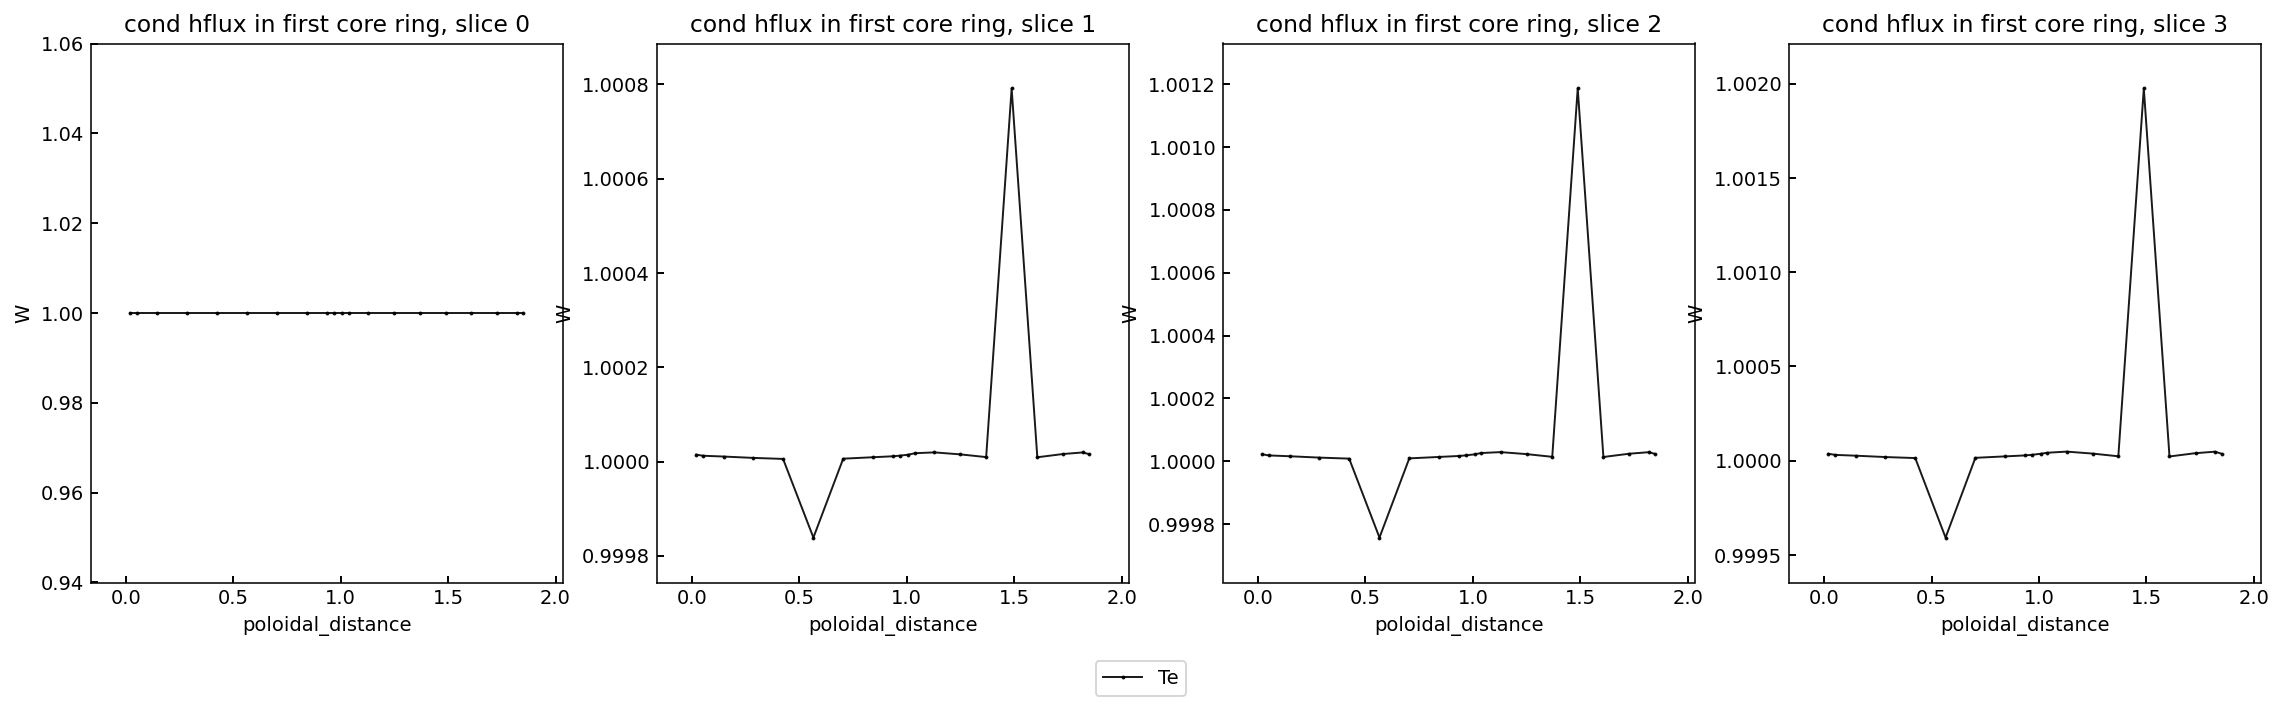

In [9]:
fig, axes = plt.subplots(1, len(time_slices), figsize = (5*len(time_slices),5))


for tind, t in enumerate(time_slices):

    ax = axes[tind]
    
    ds = cs[name].ds
    m = ds.metadata
    ixseps = m["ixseps1"]
    
    core = ds.hermesm.select_custom_core_ring(0)

    hf = core["efd_cond_par_ylow"].sel(t=t, method = "nearest")
    hf_0 = core["efd_cond_par_ylow"].sel(t=time_slices[0], method = "nearest")
    (hf / hf_0).plot(ax = ax, x = "poloidal_distance", marker = "o", lw = 1, ms = 1,  c = "k", alpha = 0.9,  label = "Te" if tind == 0 else None)

    ax.set_title(f"cond power in first core ring, slice {tind}")
    ax.set_ylabel("W")
    # ax.set_yscale("symlog", linthresh = 1e6)
    # ax.set_ylim(-1e7, 1e7)
    
fig.legend(loc = "upper center", ncols = 8, bbox_to_anchor = (0.5, 0),fontsize = "medium")


## Core ring Ne ratio

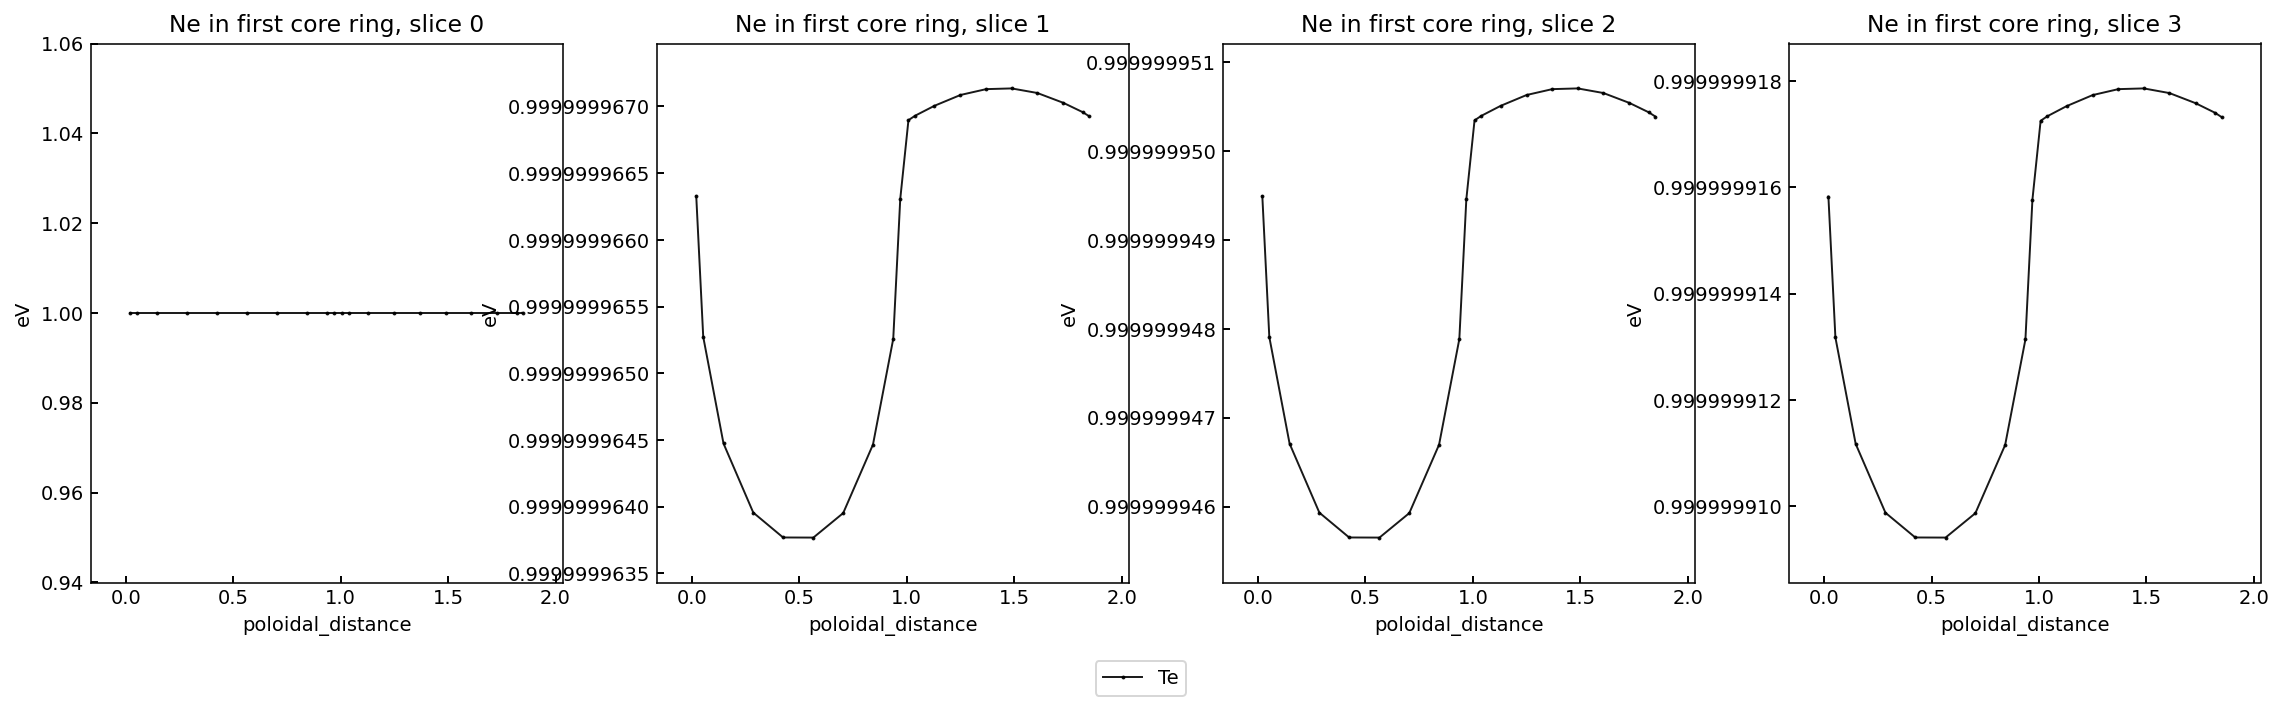

In [109]:
fig, axes = plt.subplots(1, len(time_slices), figsize = (5*len(time_slices),5))


for tind, t in enumerate(time_slices):

    ax = axes[tind]
    
    ds = cs[name].ds
    m = ds.metadata
    ixseps = m["ixseps1"]
    
    core = ds.hermesm.select_custom_core_ring(0)

    Ne = core["Ne"].sel(t=t, method = "nearest")
    Ne_0 = core["Ne"].sel(t=time_slices[0], method = "nearest")
    
    (Ne/Ne_0).plot(ax = ax, x = "poloidal_distance", marker = "o", lw = 1, ms = 1,  c = "k", alpha = 0.9,  label = "Te" if tind == 0 else None)
    
    # ax2 = ax.twinx()
    # core["Te"].sel(t=t, method = "nearest").diff("poloidal_distance").plot(ax = ax2, x = "poloidal_distance", marker = "o", lw = 1, ms = 1, c = "r", alpha = 0.9,  label = "Te" if tind == 0 else None)

    ax.set_title(f"Ne in first core ring, slice {tind}")
    
    ax.set_ylabel("eV")
    # ax.set_yscale("symlog", linthresh = 1e6)
    # ax.set_ylim(-1e7, 1e7)
    
fig.legend(loc = "upper center", ncols = 8, bbox_to_anchor = (0.5, 0),fontsize = "medium")


## Core ring N*T vs. P

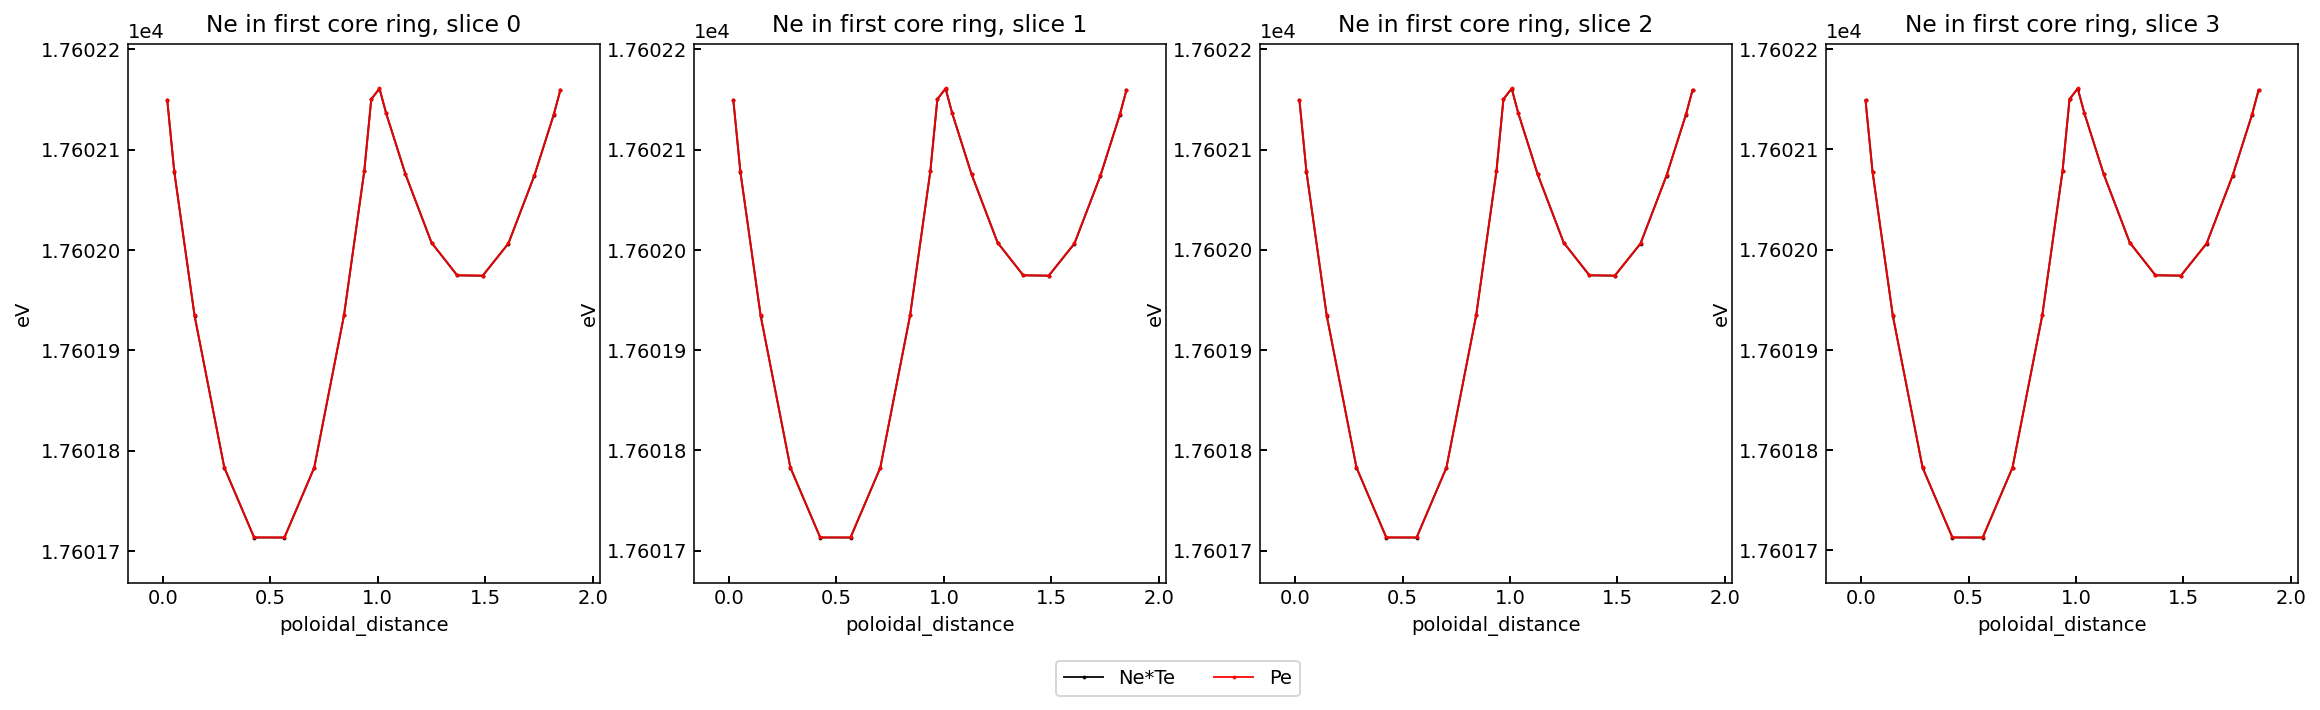

In [106]:
fig, axes = plt.subplots(1, len(time_slices), figsize = (5*len(time_slices),5))


for tind, t in enumerate(time_slices):

    ax = axes[tind]
    
    ds = cs[name].ds
    m = ds.metadata
    ixseps = m["ixseps1"]
    
    core = ds.hermesm.select_custom_core_ring(0)

    (core["Ne"] * core["Te"] * constants("q_e")).sel(t=t, method = "nearest").plot(ax = ax, x = "poloidal_distance", marker = "o", lw = 1, ms = 1,  c = "k", alpha = 0.9,  label = "Ne*Te" if tind == 0 else None)
    (core["Pe"]).sel(t=t, method = "nearest").plot(ax = ax, x = "poloidal_distance", marker = "o", lw = 1, ms = 1,  c = "r", alpha = 0.9,  label = "Pe" if tind == 0 else None)
    
    # ax2 = ax.twinx()
    # core["Te"].sel(t=t, method = "nearest").diff("poloidal_distance").plot(ax = ax2, x = "poloidal_distance", marker = "o", lw = 1, ms = 1, c = "r", alpha = 0.9,  label = "Te" if tind == 0 else None)

    ax.set_title(f"Ne in first core ring, slice {tind}")
    
    ax.set_ylabel("eV")
    # ax.set_yscale("symlog", linthresh = 1e6)
    # ax.set_ylim(-1e7, 1e7)
    
fig.legend(loc = "upper center", ncols = 8, bbox_to_anchor = (0.5, 0),fontsize = "medium")


## Core ring pressure ratio

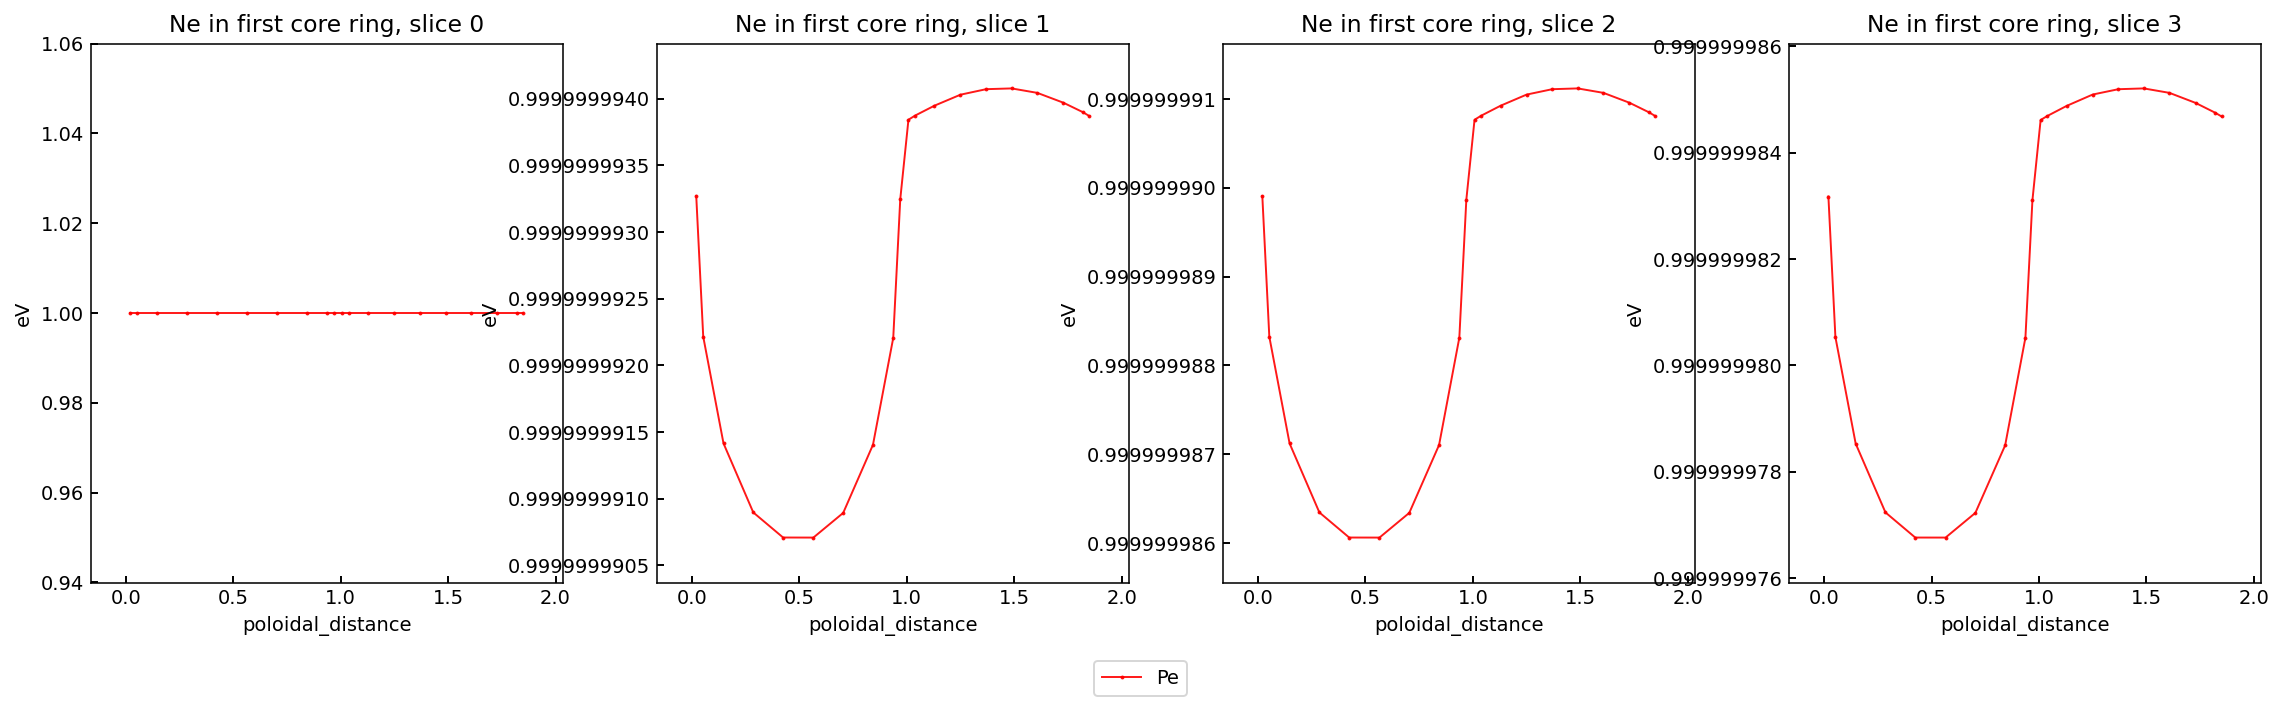

In [108]:
fig, axes = plt.subplots(1, len(time_slices), figsize = (5*len(time_slices),5))


for tind, t in enumerate(time_slices):

    ax = axes[tind]
    
    ds = cs[name].ds
    m = ds.metadata
    ixseps = m["ixseps1"]
    
    core = ds.hermesm.select_custom_core_ring(0)
    
    Pe = (core["Pe"]).sel(t=t, method = "nearest")
    Pe_0 = (core["Pe"]).sel(t=time_slices[0], method = "nearest")

    (Pe/Pe_0).plot(ax = ax, x = "poloidal_distance", marker = "o", lw = 1, ms = 1,  c = "r", alpha = 0.9,  label = "Pe" if tind == 0 else None)
    ax.set_title(f"Ne in first core ring, slice {tind}")
    ax.set_ylabel("eV")

    
fig.legend(loc = "upper center", ncols = 8, bbox_to_anchor = (0.5, 0),fontsize = "medium")


## Core ring kappa

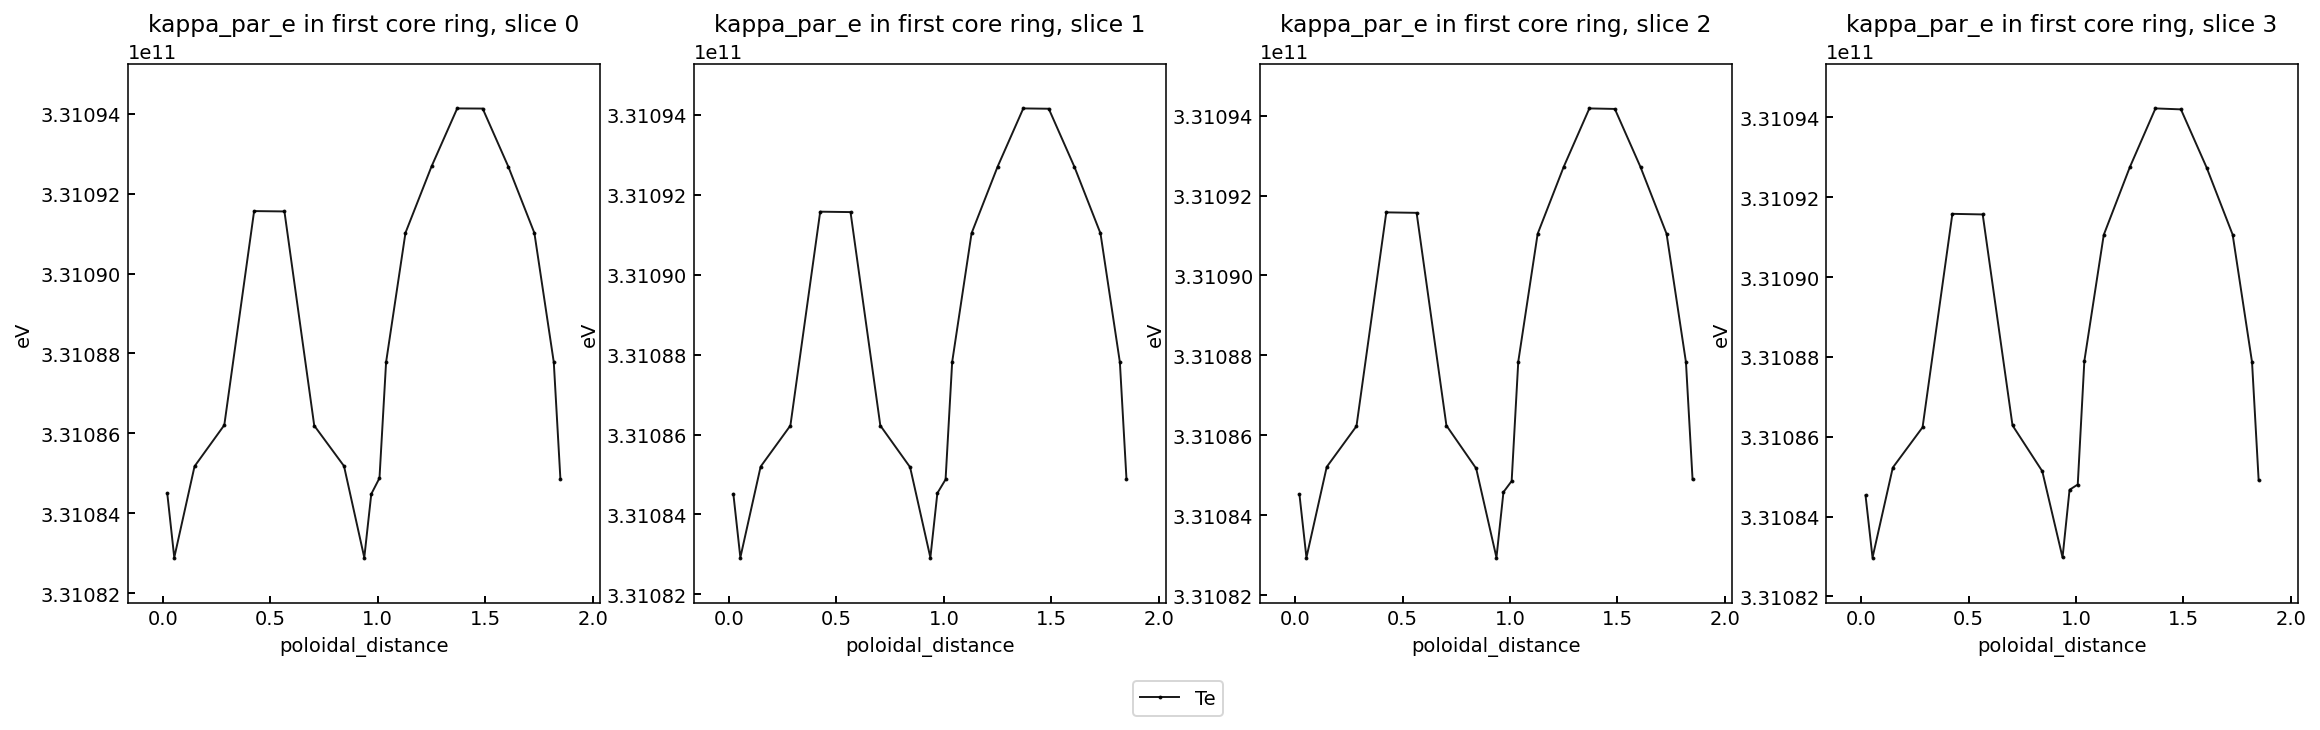

In [104]:
fig, axes = plt.subplots(1, len(time_slices), figsize = (5*len(time_slices),5))


for tind, t in enumerate(time_slices):

    ax = axes[tind]
    
    ds = cs[name].ds
    m = ds.metadata
    ixseps = m["ixseps1"]
    
    core = ds.hermesm.select_custom_core_ring(0)

    core["kappa_par_e"].sel(t=t, method = "nearest").plot(ax = ax, x = "poloidal_distance", marker = "o", lw = 1, ms = 1,  c = "k", alpha = 0.9,  label = "Te" if tind == 0 else None)
    
    
    # ax2 = ax.twinx()
    # core["Te"].sel(t=t, method = "nearest").diff("poloidal_distance").plot(ax = ax2, x = "poloidal_distance", marker = "o", lw = 1, ms = 1, c = "r", alpha = 0.9,  label = "Te" if tind == 0 else None)

    ax.set_title(f"kappa_par_e in first core ring, slice {tind}")
    
    ax.set_ylabel("eV")
    # ax.set_yscale("symlog", linthresh = 1e6)
    # ax.set_ylim(-1e7, 1e7)
    
fig.legend(loc = "upper center", ncols = 8, bbox_to_anchor = (0.5, 0),fontsize = "medium")


## kappa ratio

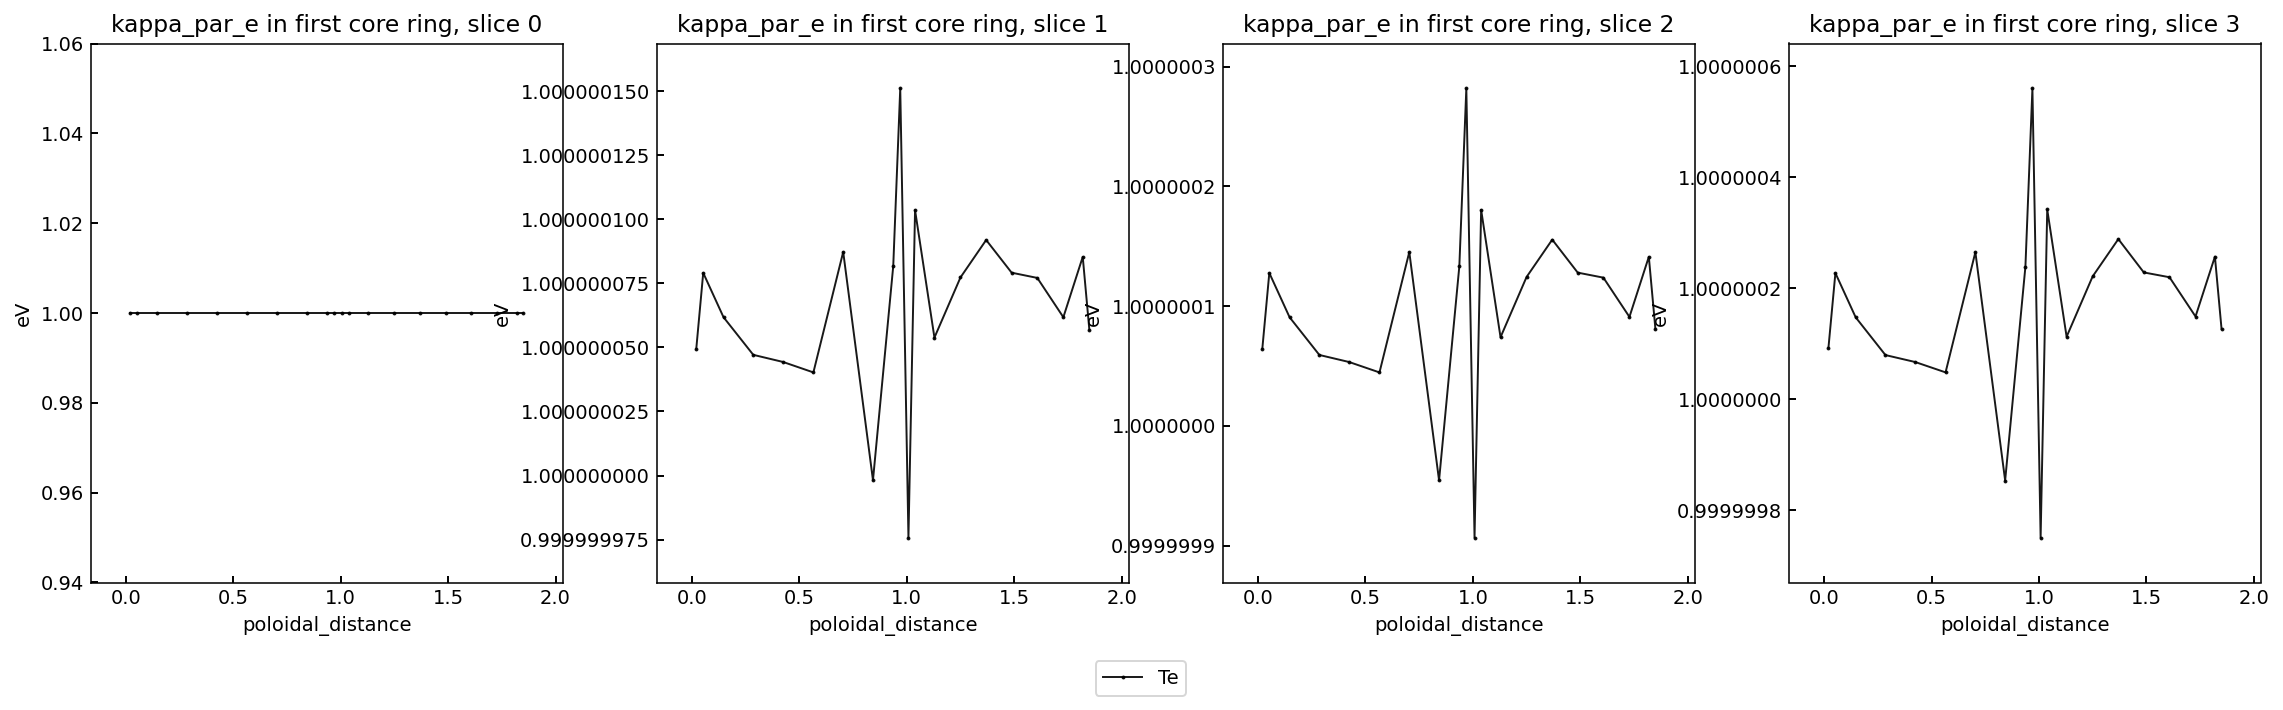

In [105]:
fig, axes = plt.subplots(1, len(time_slices), figsize = (5*len(time_slices),5))


for tind, t in enumerate(time_slices):

    ax = axes[tind]
    
    ds = cs[name].ds
    m = ds.metadata
    ixseps = m["ixseps1"]
    
    core = ds.hermesm.select_custom_core_ring(0)

    kappa = core["kappa_par_e"].sel(t=t, method = "nearest")
    kappa0 = core["kappa_par_e"].sel(t=time_slices[0], method = "nearest")
    
    
    (kappa / kappa0).plot(ax = ax, x = "poloidal_distance", marker = "o", lw = 1, ms = 1,  c = "k", alpha = 0.9,  label = "Te" if tind == 0 else None)
    
    
    # ax2 = ax.twinx()
    # core["Te"].sel(t=t, method = "nearest").diff("poloidal_distance").plot(ax = ax2, x = "poloidal_distance", marker = "o", lw = 1, ms = 1, c = "r", alpha = 0.9,  label = "Te" if tind == 0 else None)

    ax.set_title(f"kappa_par_e in first core ring, slice {tind}")
    
    ax.set_ylabel("eV")
    # ax.set_yscale("symlog", linthresh = 1e6)
    # ax.set_ylim(-1e7, 1e7)
    
fig.legend(loc = "upper center", ncols = 8, bbox_to_anchor = (0.5, 0),fontsize = "medium")


## Momentum

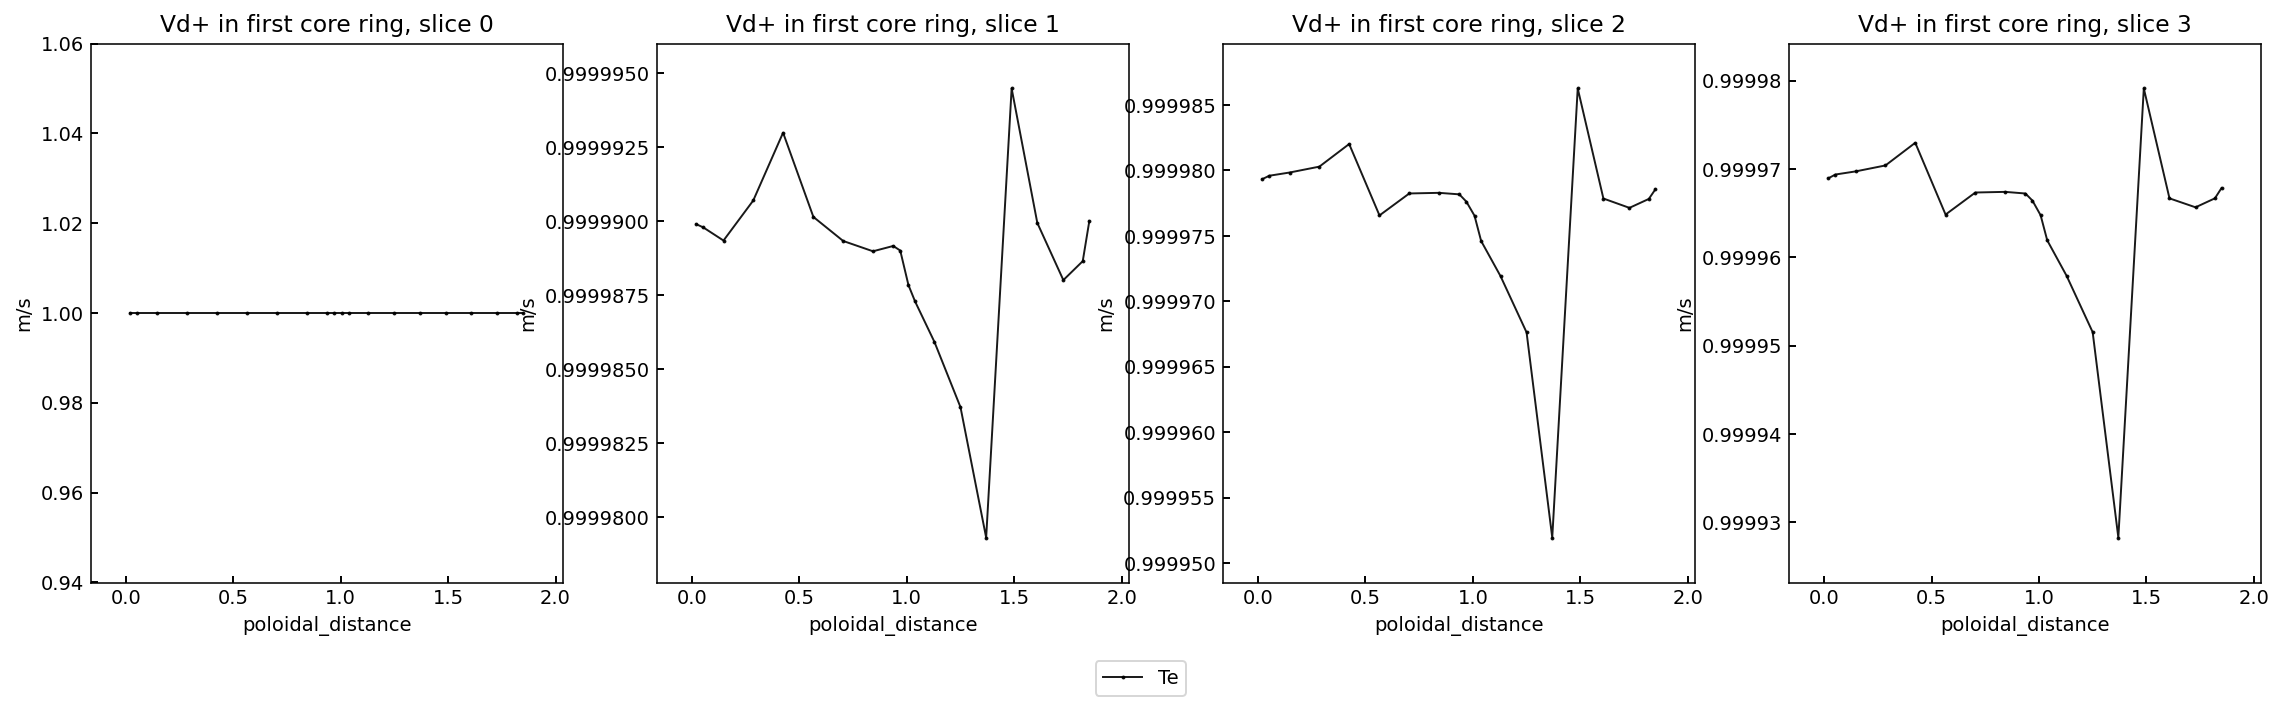

In [49]:
fig, axes = plt.subplots(1, len(time_slices), figsize = (5*len(time_slices),5))


for tind, t in enumerate(time_slices):

    ax = axes[tind]
    
    ds = cs[name].ds
    m = ds.metadata
    ixseps = m["ixseps1"]
    
    core = ds.hermesm.select_custom_core_ring(0)

    Vi = core["Vd+"].sel(t=t, method = "nearest")
    Vi0 = core["Vd+"].sel(t=time_slices[0], method = "nearest")
    
    (Vi / Vi0).plot(ax = ax, x = "poloidal_distance", marker = "o", lw = 1, ms = 1,  c = "k", alpha = 0.9,  label = "Te" if tind == 0 else None)
    
    
    # ax2 = ax.twinx()
    # core["Te"].sel(t=t, method = "nearest").diff("poloidal_distance").plot(ax = ax2, x = "poloidal_distance", marker = "o", lw = 1, ms = 1, c = "r", alpha = 0.9,  label = "Te" if tind == 0 else None)

    ax.set_title(f"Vd+ in first core ring, slice {tind}")
    
    ax.set_ylabel("m/s")
    # ax.set_yscale("symlog", linthresh = 1e6)
    # ax.set_ylim(-1e7, 1e7)
    
fig.legend(loc = "upper center", ncols = 8, bbox_to_anchor = (0.5, 0),fontsize = "medium")


# 2D plots

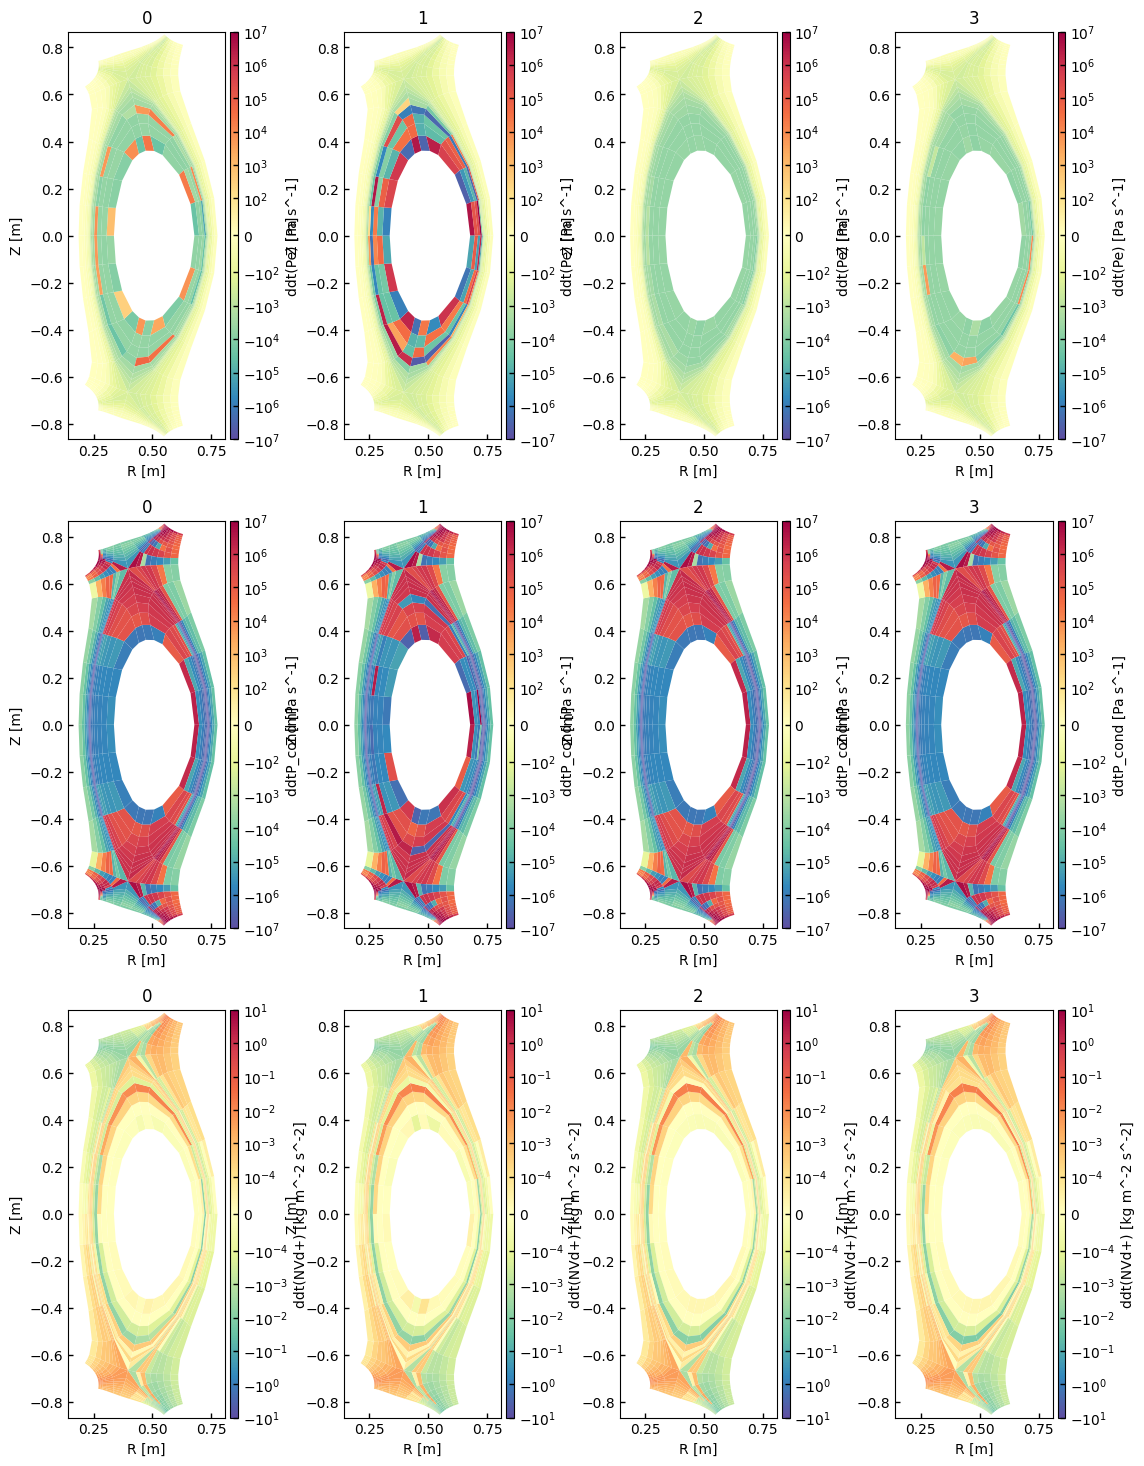

In [ ]:
ds = cs["base"].ds
no_times = len(tind_slices)
fig, axes = plt.subplots(3 ,no_times, figsize = (3.1*no_times*1.1,4.5*2*2), dpi = 100)
style = dict(cmap = "Spectral_r", targets = False, separatrix_kwargs = dict(
    color="white", linestyle = "-", linewidth = 0),antialias = True,
             logscale = True)

for i, time in enumerate(tind_slices):
    
    ax = axes[0,i]
    ds["ddt(Pe)"].sel(t=time).hermesm.clean_guards().bout.polygon(ax = ax, vmin = -1e7, vmax = 1e7, **style)
    ax.set_title(f"{i}")
    
    ax = axes[1,i]
    ds["ddtP_cond"].sel(t=time).hermesm.clean_guards().bout.polygon(ax = ax, vmin = -1e7, vmax = 1e7, **style)
    ax.set_title(f"{i}")
    
    ax = axes[2,i]
    ds["ddt(NVd+)"].sel(t=time).hermesm.clean_guards().bout.polygon(ax = ax, vmin = -0.5, vmax = 0.5, **style)
    ax.set_title(f"{i}")
    